### Setting up Your Local Spark Cluster

I found these two sites to be useful for installing spark, setting up a local cluster, and linking spark to ipython:

https://districtdatalabs.silvrback.com/getting-started-with-spark-in-python

http://pulasthisupun.blogspot.ca/2013/11/how-to-set-up-apache-spark-cluster-in.html

To set up a cluster locally you must ensure that your computer can ssh into itself (the slaves have to be able to ssh into the master for spark to connect properly).  The status of your local spark cluster can be monitored through the WebUI at http://localhost:8080.

### My Configuration

I don't claim to be an expert, for me this is still experimental.  
My computer has 4 cores and 16 GB of RAM.

I set up 4 workers, each with 3GB and 1 core

$SPARK_HOME/spark-1.3.1/conf/spark-env.sh:

In [ ]:
#!/usr/bin/env bash

export SCALA_HOME=/usr/local/Cellar/scala/2.11.5/libexec/
export SPARK_WORKER_CORES=1
export SPARK_WORKER_MEMORY=3g
export SPARK_WORKER_INSTANCES=4
export SPARK_WORKER_DIR=/Users/brock.moir/tempdata/sparkdata

I noticed that the executor defaults to only 512MB.  I interpreted this as being the memory assigned to each worker for each application.  I set the default to 3GB for two reasons:

I am the only one using this cluster so I want to use all the resources

I couldn't generate a SparkContext with a properly configured SparkConf object which would allow me to change this setting

spark-1.3.1/conf/spark-defaults.conf:

In [ ]:
spark.executor.memory   3g

Finally, I found the default verbosity of spark to make debugging my code even more frustrating than it should be.  I set it print WARN or worse, otherwise it burried any python runtime errors in useless INFO statements.  When running in notebook, I can check the errors and warnings from the terminal.

This is done by changing all the INFO flags in $SPARK_HOME/spark-1.3.1/conf/log4j.properties to WARN

### The Spark Context

From https://spark.apache.org/docs/1.2.1/api/scala/index.html#org.apache.spark.SparkContext:

"Main entry point for Spark functionality. A SparkContext represents the connection to a Spark cluster, and can be used to create RDDs, accumulators and broadcast variables on that cluster.

Only one SparkContext may be active per JVM. You must stop() the active SparkContext before creating a new one. This limitation may eventually be removed; see SPARK-2243 for more details."

Here I have connected the context to my local spark cluster.  When we are done with our context, we can stop it using sc.stop()

In [1]:
from pyspark import  SparkContext
sc = SparkContext( 'spark://pulmac27.local:7077', 'Average Pixels')

In [7]:
sc.stop()

### An Example

Now that Spark is installed and configured and we have a context pointing us to a cluster, we can run Spark jobs and take avantage of Spark's lightning fast analysis capabilities.  

For this project I will be working with the MNIST Handwritten digits data that can be found among other places here: https://www.kaggle.com/c/digit-recognizer/data.  

I will do a simple analysis to get the average pixel values for each digit similar to that done on forum thread: https://www.kaggle.com/c/digit-recognizer/forums/t/12822/plot-the-digits-using-average-of-the-corresponding-pixels.

The training data is stored as a csv with each row giving the digit followed by a list of the flattened 28 x 28 pixel value matrix.

In [2]:
filepath = "/Users/brock.moir/MyProjects/MNIST-Spark/data/"
pixel_labels = open(filepath + "headers.txt").read().split(',')[1:]

In [3]:
train_rdd = sc.textFile(filepath + "train.csv", minPartitions = 4)

### Structuring a Job

To use the methods available in Spark core we need to break the analysis up into a few steps.  

First we need to parse each line of the csv to produce a paired RDD consisting of keys (digits) and values (list of pixel values and initial count pairs) that can then be combined with a reduce method.  

The reduction function is an instruction that tells spark how to combine the values associated to the same key.  In our case we want to average each pixel, so we sum each pixel value and sum the counts of the number of unique values in each sum.

The final step is to calculate the pixel means from the reduced RDD with a mapping function that divides the total sum by the total count (this could probably be done in the reduction step as well, I will leave it as an exercise for the reader).

Each step of the analysis requires its own function:

In [4]:
def parseLine(line): 
    line = line.split(",")
    key = line[0]
    pixels = line[1:]
    value = []
    for pixel in range(len(pixels)):
        value.append([float(pixels[pixel]), 1.])  
    return key, value

def reduceValues(value1, value2):
    new_value = []
    for pixel in range(len(value1)):
        new_value.append([value1[pixel][0] + value2[pixel][0], 
                          value1[pixel][1] + value2[pixel][1]])
    return new_value

def getMeans(line):
    key, value = line[0], line[1]
    new_value = []
    for pixel in range(len(value)):
        psum, pcount = value[pixel][0], value[pixel][1]
        new_value.append(psum/pcount)
    return key, new_value  

The pixel means are found below by mapping, reducing, then a final mapping.  Spark is able to sort the RDD by keys, which puts the digits in the correct order.  Finally we ask spark to calculate these values by calling collect().


The spark job will not kick off until you ask it to return a value (.collect() here returns all the key value pairs defined in getMeans()).  

At this point I will no longer need my spark context, so I end it using sc.stop().

In [5]:
pixel_means = train_rdd.map(lambda line: parseLine(line))\
.reduceByKey(lambda v1, v2: reduceValues(v1, v2))\
.map(lambda line: getMeans(line)).sortByKey(True).collect()

### Plotting the Results

Now I have what I need to plot the average handwritten digit, I just need to restructure each digit's list and then plot the pixels.

The final result is a visualization of the similarities in how each number is written across this population.

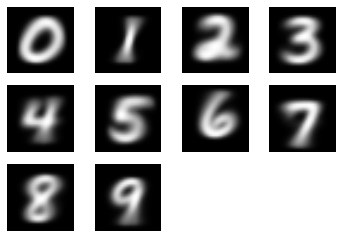

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

size = (28,28)

for digit in range(len(pixel_means)):
    index = int(pixel_means[digit][0])
    pixel_means[index] = np.array(pixel_means[digit][1])
    pixel_means[index] = pixel_means[index].reshape(size)
    
    plt.subplot(3,4,digit+1)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.imshow(pixel_means[digit], cmap = cm.Greys_r)